In [404]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
import datetime

# Kalshi
import kalshi_python
from KalshiClientsBaseV2 import ExchangeClient
import time
import json
import uuid

# API
import requests
from bs4 import BeautifulSoup

# ML
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

## Data Gathering and Evaluation
I found 5 sources for daily weather data in New York City as follows:
1. National Centers for Environmental Information (NCEI)
2. National Weather Service
3. Visual Crossing
4. Meteomatics
5. Yahoo Weather

### National Weather Service

I was initially thrilled about the this data source, as it closely aligns with what's behind Kalshi's weather event trading. However, upon delving into their API documentation, my excitement was met with a degree of disappointment. It became evident that while they only offer forecast weather data through their API, and the data available for direct download is confined to a-month record. This limitation prompted me to explore alternative data sources that better suit the needs.

In [ ]:
# Define the URL for NYC data
url = "https://forecast.weather.gov/MapClick.php?lat=40.714530000000025&lon=-74.00711999999999"

# Send a GET request to the URL
response = requests.get(url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Parse the HTML content
    soup = BeautifulSoup(response.text, "html.parser")
    observed_data_divs = soup.find_all("div", class_="tombstone-container")

    timestamps = []
    temperatures = []

    # Extract data from API
    for observed_div in observed_data_divs:
        timestamp = observed_div.find("p", class_="period-name").get_text(strip=True)
        temperature = observed_div.find("p", class_="temp").get_text(strip=True)
        timestamps.append(timestamp)
        temperatures.append(temperature)

    # Store data
    nws_data = pd.DataFrame({
        "Timestamp": timestamps,
        "Temperature (Fahrenheit)": temperatures
    })
    print("API request successful")
else:
    print(f"API request failed with status code {response.status_code}")

API request successful


### National Centers for Environmental Information (NCEI)

In [405]:
# Define the URL for NYC data
url = "https://www.ncei.noaa.gov/cdo-web/api/v2/data"

# Define the query parameters
start_date = datetime.datetime.strptime("2019-08-01", "%Y-%m-%d").date()
last_date = datetime.datetime.strptime("2023-08-01", "%Y-%m-%d").date()
api = pd.DataFrame()

# Loop through the request because of the limit on the number of records per request
while start_date <= last_date:
    end_date = min(start_date + datetime.timedelta(days=100), last_date)
    params = {
        "datasetid": "GHCND",
        "stationid": "GHCND:USW00094728",
        "startdate": start_date,
        "enddate": end_date,
        "units": "standard",
        "datatypeid": "AWND,PRCP,SNOW,SNWD,TMAX,TMIN,WT01,WT03,WT08",
        "limit": 1000
    }
    print(start_date)
    print(end_date)
    # API request
    response = requests.get(url, params=params, headers={"token": "hQjOAltlsPnryPJlIEkjkzQqJFPtGOpe"})
    start_date = end_date + datetime.timedelta(days=1)
    if response.status_code == 200:
        print("API request successful")
        # Convert JSON to DataFrame
        json_data = pd.DataFrame(response.json()["results"])
        result = pd.DataFrame(json_data)
        api = api.append(json_data)
    else:
        print(f"API request failed with status code {response.status_code}")

2019-08-01
2019-11-09
API request successful
2019-11-10
2020-02-18


C:\Users\pnhua\AppData\Local\Temp\ipykernel_17432\1406861005.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  api = api.append(json_data)


API request successful
2020-02-19
2020-05-29


C:\Users\pnhua\AppData\Local\Temp\ipykernel_17432\1406861005.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  api = api.append(json_data)


API request successful
2020-05-30
2020-09-07


C:\Users\pnhua\AppData\Local\Temp\ipykernel_17432\1406861005.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  api = api.append(json_data)


API request successful
2020-09-08
2020-12-17


C:\Users\pnhua\AppData\Local\Temp\ipykernel_17432\1406861005.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  api = api.append(json_data)


API request successful
2020-12-18
2021-03-28


C:\Users\pnhua\AppData\Local\Temp\ipykernel_17432\1406861005.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  api = api.append(json_data)


API request successful
2021-03-29
2021-07-07


C:\Users\pnhua\AppData\Local\Temp\ipykernel_17432\1406861005.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  api = api.append(json_data)


API request successful
2021-07-08
2021-10-16


C:\Users\pnhua\AppData\Local\Temp\ipykernel_17432\1406861005.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  api = api.append(json_data)


API request successful
2021-10-17
2022-01-25


C:\Users\pnhua\AppData\Local\Temp\ipykernel_17432\1406861005.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  api = api.append(json_data)


API request successful
2022-01-26
2022-05-06


C:\Users\pnhua\AppData\Local\Temp\ipykernel_17432\1406861005.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  api = api.append(json_data)


API request successful
2022-05-07
2022-08-15


C:\Users\pnhua\AppData\Local\Temp\ipykernel_17432\1406861005.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  api = api.append(json_data)


API request successful
2022-08-16
2022-11-24


C:\Users\pnhua\AppData\Local\Temp\ipykernel_17432\1406861005.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  api = api.append(json_data)


API request successful
2022-11-25
2023-03-05


C:\Users\pnhua\AppData\Local\Temp\ipykernel_17432\1406861005.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  api = api.append(json_data)


API request successful
2023-03-06
2023-06-14


C:\Users\pnhua\AppData\Local\Temp\ipykernel_17432\1406861005.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  api = api.append(json_data)


API request successful
2023-06-15
2023-08-01


C:\Users\pnhua\AppData\Local\Temp\ipykernel_17432\1406861005.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  api = api.append(json_data)


API request successful


C:\Users\pnhua\AppData\Local\Temp\ipykernel_17432\1406861005.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  api = api.append(json_data)


### Visual Crossing

I attempted to pull the data from Visual Crossing's API, but unfortunately there're limits on the amount of records per request and on the number of calls every day. I ended up having to download csv data from their website.

In [406]:
# Define the URL for NYC data
url = "https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/New%20York%20City%2CUSA/2020-11-01/2021-11-01"
# Define the query parameters
params = {
    "unitGroup": "us",
     "include": "day",
    "key": "WS8SPUNTV45687SM8PE4SP8EC",
    "contentType": "csv"
}
    # API request
response = requests.get(url)
if response.status_code == 200:
    print("API request successful")
    # Convert csv to DataFrame
    csv_data = pd.DataFrame(response)
else:
    print(f"API request failed with status code {response.status_code}")


API request failed with status code 401


In [407]:
vs_df = pd.read_csv("visual_crossing.csv")

# Select only relevant columns
vs_df = vs_df[['datetime', 'tempmax', 'dew', 'humidity', 'precip', 'windgust',
       'windspeed', 'sealevelpressure', 'solarradiation', 'solarenergy']]

# Convert datetime column to datetime data type
vs_df['datetime'] = pd.to_datetime(vs_df['datetime'])

### Yahoo Weather

Yahoo Weather does not allow me to scrape historical data. They mostly have just forecast data.

In [153]:
yahoo = pd.read_html("https://www.yahoo.com/news/weather/united-states/new-york/new-york-2459115")
print(yahoo)

[                               Day Weather Condition     Precipitation  \
0    View forecast detailsThursday               NaN   Precipitation0%   
1      View forecast detailsFriday               NaN  Precipitation10%   
2    View forecast detailsSaturday               NaN  Precipitation71%   
3      View forecast detailsSunday               NaN  Precipitation51%   
4      View forecast detailsMonday               NaN  Precipitation40%   
5     View forecast detailsTuesday               NaN  Precipitation60%   
6   View forecast detailsWednesday               NaN  Precipitation56%   
7    View forecast detailsThursday               NaN   Precipitation0%   
8      View forecast detailsFriday               NaN  Precipitation77%   
9    View forecast detailsSaturday               NaN  Precipitation80%   
10     View forecast detailsSunday               NaN  Precipitation56%   
11                           5-DAY            10-DAY               NaN   

                                    

Gathering relevant weather data to predict the daily maximum temperature in New York was a challenging endeavor. Identifying credible and dependable data sources was not easy. Once I had pinpointed these sources, I encountered further obstacles in scraping or downloading the data. The insufficiency of some API documentation added a layer of complexity, as understanding how to extract the right data often demanded a significant investment of time and effort.

I faced numerous hurdles, such as locating station ID numbers, circumventing the limitations on API calls, and, in some cases, having to consider the costs associated with certain APIs. While it may seem that there is a plethora of weather data available, it became clear that only a handful of sources provided data that was truly usable for my prediction task. Some sources offered solely monthly or historical data with a limited time frame, while others provided only forecast data. 

After a thorough assessment of these challenges and limitations, I decided to rely on data from source NCEI as my foundation for processing and predicting daily maximum temperatures because it is the most consistent dataset. The only downside I have noticed is that the data does not update daily as expected, especially when we approach weekends or holidays.

## Data Processing

### NCEI Data

In [408]:
# Create a function to process NCEI data pulled from API
def ncei_processing(df):
    # Unpivot relevant columns
    processed_df = df.pivot(index='date', columns=['datatype'], values='value')
    processed_df = processed_df.reset_index()

    # Rename columns to be descriptive
    processed_df = processed_df.rename(columns={'AWND':'avg wind speed',
                                                'PRCP':'precipitation',
                                                'SNOW':'snowfall',
                                                'SNWD':'snow depth',
                                                'TMAX':'max temp',
                                                'TMIN':'min temp',
                                                'WT01':'fog',
                                                'WT03':'thunder',
                                                'WT08':'smoke/haze'})

    # Process NaN values
    processed_df = processed_df.dropna(subset=['avg wind speed',
                                               'precipitation',
                                               'snowfall',
                                               'snow depth',
                                               'max temp',
                                               'min temp'])
    processed_df = processed_df.fillna(0) 

    # Extract date elements
    processed_df['date'] = pd.to_datetime(processed_df['date'])
    processed_df['year'] = processed_df['date'].dt.year
    processed_df['month'] = processed_df['date'].dt.month
    processed_df['day'] = processed_df['date'].dt.day
    processed_df['quarter'] = processed_df['date'].dt.quarter
    return processed_df

ncei_df = ncei_processing(api)

Text(0, 0.5, 'Temperature (°F)')

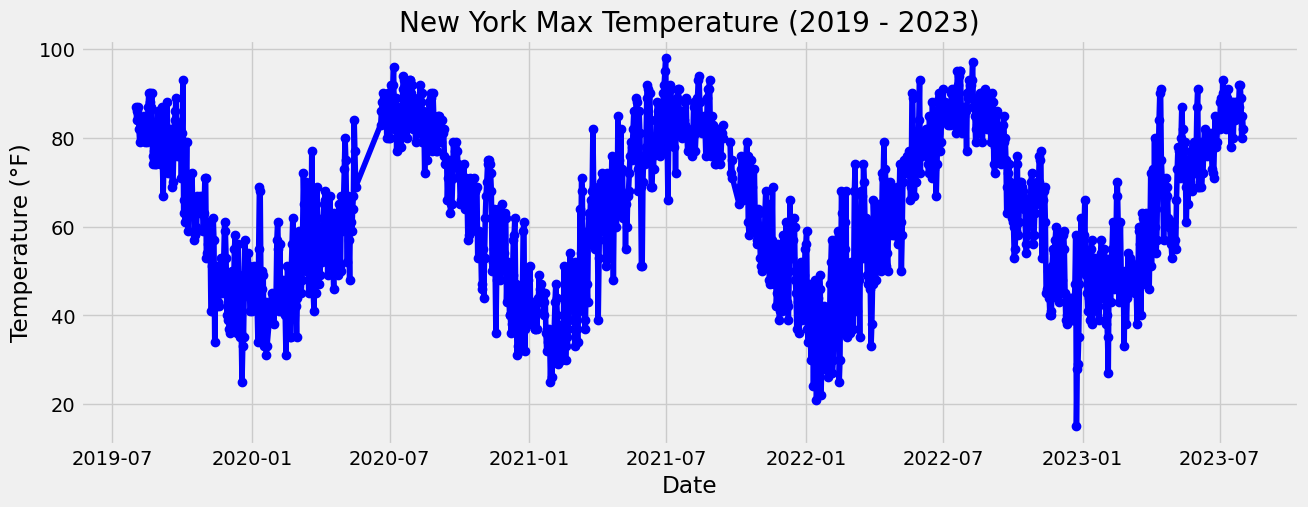

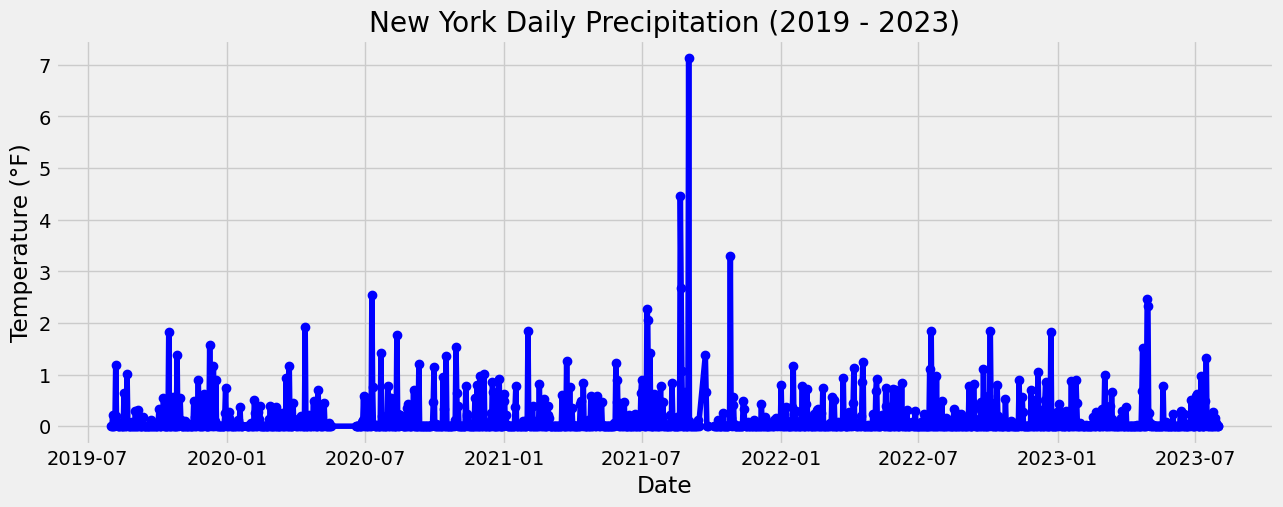

In [409]:
# Set 'Date' as the index
ncei_df.set_index('date', inplace=True)
# # Visualize the data
plt.figure(figsize=(14, 5))
plt.plot(ncei_df.index, ncei_df['max temp'], marker='o', linestyle='-', color='b')
plt.title('New York Max Temperature (2019 - 2023)')
plt.xlabel('Date')
plt.ylabel('Temperature (°F)')

plt.figure(figsize=(14, 5))
plt.plot(ncei_df.index, ncei_df['precipitation'], marker='o', linestyle='-', color='b')
plt.title('New York Daily Precipitation (2019 - 2023)')
plt.xlabel('Date')
plt.ylabel('Temperature (°F)')

### Visual Crossing Data

Text(0, 0.5, 'Temperature (°F)')

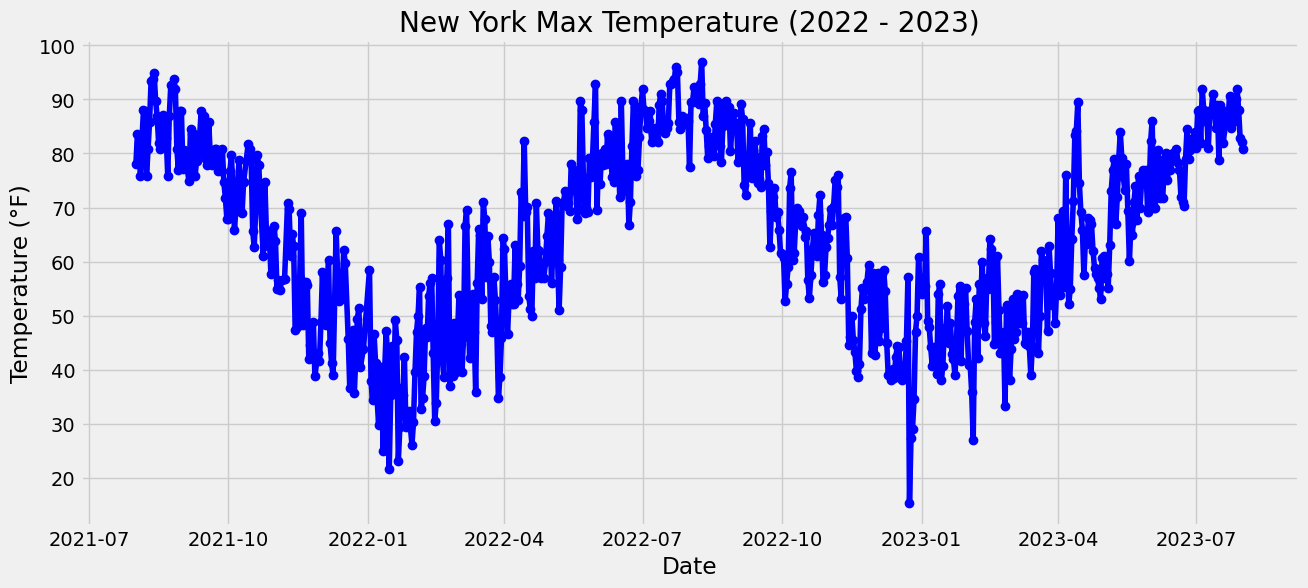

In [410]:
# Drop NaN values
vs_df = vs_df.dropna()
# Set 'Date' as the index (required for time series plotting)
vs_df.set_index('datetime', inplace=True)
# Create the time series plot
plt.figure(figsize=(14, 6))
plt.plot(vs_df.index, vs_df['tempmax'], marker='o', linestyle='-', color='b')
plt.title('New York Max Temperature (2022 - 2023)')
plt.xlabel('Date')
plt.ylabel('Temperature (°F)')

## Model Training and Selection
### Linear Regression

#### Visual Crossing Data

Mean Squared Error: 45.42519801375118
Root Mean Squared Error: 6.739821808753639


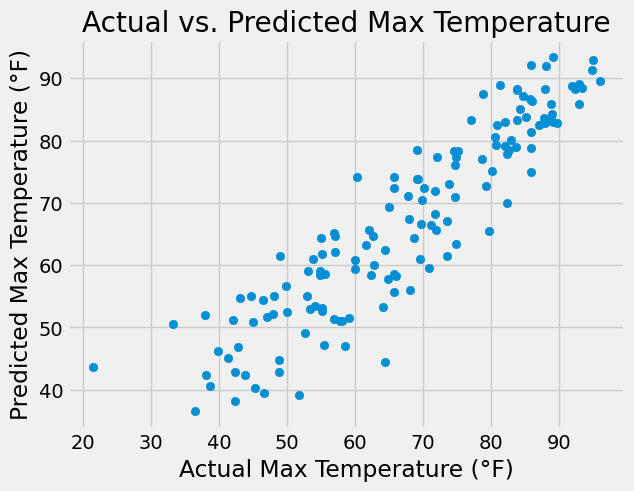

In [411]:
# Shift the max temp by one row to predict next day's max temperature
vs_df_shift = vs_df.copy()
vs_df_shift['tempmax_next'] = vs_df_shift['tempmax'].shift(-1)

# Remove the first and last row because of the shift
vs_df_shift = vs_df_shift.iloc[1:-1]

# Define features (x) and the target variable (y)
x = vs_df_shift[['tempmax', 'dew', 'humidity', 'precip', 'windgust', 'windspeed', 'sealevelpressure', 'solarradiation', 'solarenergy']]
y = vs_df_shift['tempmax_next']

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Grid search for optimal parameters for a ridge linear regression model
param_grid = {'alpha': [0.1, 1, 10]}
grid_search = GridSearchCV(Ridge(), param_grid, cv=5)
grid_search.fit(x_train, y_train)
best_alpha = grid_search.best_params_['alpha']

# Fit the model
best_model = Ridge(alpha=best_alpha)
best_model.fit(x_train, y_train)

# Make predictions on the test data
y_pred = best_model.predict(x_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')

# Visualize the actual vs. predicted values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Max Temperature (°F)')
plt.ylabel('Predicted Max Temperature (°F)')
plt.title('Actual vs. Predicted Max Temperature')
plt.show()

#### NCEI Data

The best alpha is 10
Mean Squared Error: 48.05341001951685
Root Mean Squared Error: 6.9320566947708135


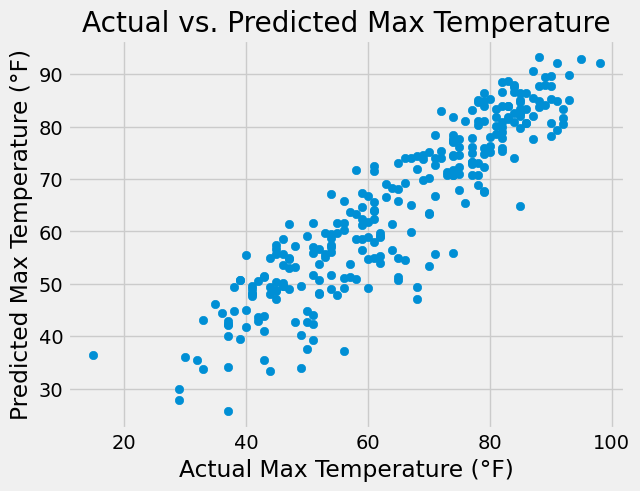

In [412]:
# Shift the max temp by one row to predict next day's max temperature
ncei_df_shift = ncei_df.copy()
ncei_df_shift['max temp next'] = ncei_df_shift['max temp'].shift(-1)

# Remove the first and last row because of the shift
ncei_df_shift = ncei_df_shift.iloc[1:-1]

# Define features (x) and the target variable (y)
x = ncei_df_shift[['avg wind speed','precipitation','snowfall','snow depth','min temp','max temp','fog','thunder','smoke/haze']]
y = ncei_df_shift['max temp next']

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Grid search for optimal parameters for a ridge linear regression model
param_grid = {'alpha': [0.1, 1, 10]}
grid_search = GridSearchCV(Ridge(), param_grid, cv=5)
grid_search.fit(x_train, y_train)
best_alpha = grid_search.best_params_['alpha']
print(f'The best alpha is {best_alpha}')

# Fit the model
best_model = Ridge(alpha=best_alpha)
best_model.fit(x_train, y_train)

# Make predictions on the test data
y_pred = best_model.predict(x_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')

# Visualize the actual vs. predicted values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Max Temperature (°F)')
plt.ylabel('Predicted Max Temperature (°F)')
plt.title('Actual vs. Predicted Max Temperature')
plt.show()

Building a robust linear regression model was a meticulous process that involved several critical steps. To ensure the model's optimal performance, I employed a grid search to fine-tune its parameters. This systematic search exhaustively explored all possible parameter combinations, allowing me to pinpoint the regularization term that delivered the most accurate results. Through the grid search, I found out that the optimal alpha was 10. 

### Long Short Term Memory (LSTM)

From the above visualizations of the daily temperature, I realized that there is seasonality factor, and thought it would be appropriate to try implementing a Long Short Term Memory (LSTM) modelfor the following reasons:
1. Weather data is inherently sequential, where past conditions can significantly impact future conditions. LSTM can handle sequential data and capture long-range dependencies. They can effectively model the temporal relationships in weather data..

2. LSTM can automatically learn relevant features from the data, reducing the need for manual feature engineering. They can extract complex patterns and relationships within the data, such as the impact of multiple weather variables on future conditions.

3. Weather forecasting often involves multiple variables (e.g., temperature, precipitation, wind speed) that interact with each other. LSTM can handle multivariate time series data and model complex, nonlinear relationships in weather data.

### Multivariate LSTM

In [418]:
# Extract the feature and target data
features = ncei_df[['avg wind speed','precipitation','snowfall','snow depth','min temp','max temp']].values.astype(float)
target = ncei_df['max temp'].values.astype(float)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)
scaled_target = scaler.fit_transform(target.reshape(-1, 1))

# Define the number of time steps and features
n_steps = 30
n_features = features.shape[1]

# Create sequences for training
x, y = [], []
for i in range(len(ncei_df) - n_steps):
    x.append(scaled_features[i:i + n_steps, :])
    y.append(scaled_target[i + n_steps])

x, y = np.array(x), np.array(y)

# Split the data into training, validation and testing sets
train_size = int(0.8 * len(ncei_df))
val_size = int(0.9 * len(ncei_df))
x_train, x_val, x_test = x[:train_size], x[train_size:val_size], x[val_size:]
y_train, y_val, y_test =  y[:train_size], y[train_size:val_size], y[val_size:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(n_steps, n_features)))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics='mean_squared_error')
model.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_37 (LSTM)              (None, 64)                18176     
                                                                 
 dense_59 (Dense)            (None, 16)                1040      
                                                                 
 dense_60 (Dense)            (None, 1)                 17        
                                                                 
Total params: 19233 (75.13 KB)
Trainable params: 19233 (75.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In training these LSTM models, I monitored validation loss and stopped training when the metric starts to degrade or level off. Here are the reasons why I implemented early stopping:
1. Preventing Overfitting: Early stopping helps by halting training when the model's performance on a validation dataset starts to degrade, indicating overfitting.

2. Optimizing Training Time: Training LSTMs can be computationally expensive and time-consuming. Early stopping allows me to save time and resources by avoiding unnecessary training epochs. When the model reaches an optimal level of performance, the model will stop training early rather than running for a fixed number of epochs.

3. Automating Model Selection: Early stopping automates the process of selecting the optimal number of training epochs. Instead of manually specifying the number of epochs, early stopping dynamically determines the stopping point based on the model's performance.

In [419]:
# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,         
                               restore_best_weights=True) 

# Train the model
history = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_val, y_val), callbacks=[early_stopping])

Epoch 1/100


36/36 [==============================] - 3s 24ms/step - loss: 0.0365 - mean_squared_error: 0.0365 - val_loss: 0.0123 - val_mean_squared_error: 0.0123
Epoch 2/100
36/36 [==============================] - 0s 13ms/step - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0128 - val_mean_squared_error: 0.0128
Epoch 3/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0098 - mean_squared_error: 0.0098 - val_loss: 0.0117 - val_mean_squared_error: 0.0117
Epoch 4/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0094 - mean_squared_error: 0.0094 - val_loss: 0.0117 - val_mean_squared_error: 0.0117
Epoch 5/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0096 - mean_squared_error: 0.0096 - val_loss: 0.0114 - val_mean_squared_error: 0.0114
Epoch 6/100
36/36 [==============================] - 1s 14ms/step - loss: 0.0091 - mean_squared_error: 0.0091 - val_loss: 0.0110 - val_mean_squared_error: 0.0110
Epoch 7/100
36/36 [=====================

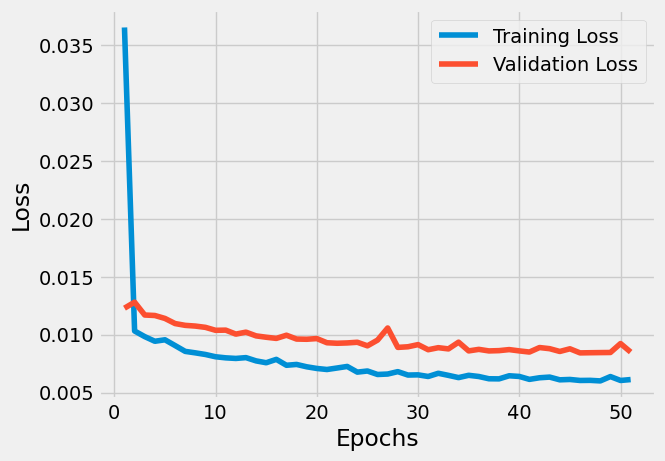

In [420]:
# Create a range of epochs
best_epoch = 51
epochs = range(1, best_epoch+1)

# Plot training and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

4/4 [==============================] - 0s 9ms/step
Root Mean Squared Error (RMSE): 5.687603488743803


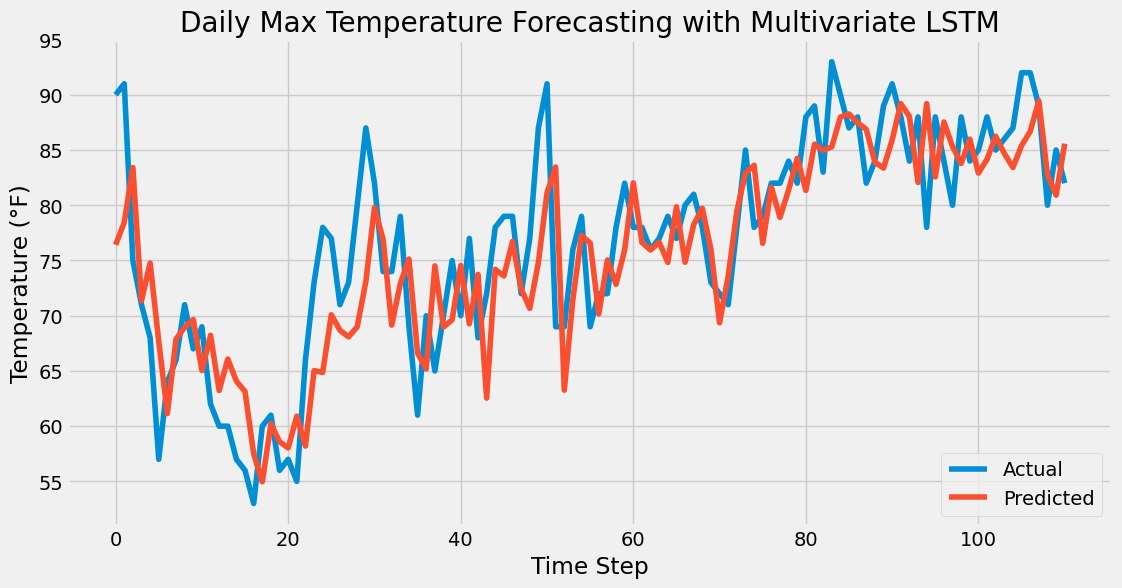

In [421]:
# Make predictions
y_pred = model.predict(x_test)

# Inverse transform the predictions to get real values
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Plot actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.xlabel('Time Step')
plt.ylabel('Temperature (°F)')
plt.title('Daily Max Temperature Forecasting with Multivariate LSTM')
plt.show()

### Univariate LSTM

In [422]:
# Extract the temperature values and convert them to an array
temperatures = ncei_df['max temp'].values.astype(float)

# Normalize the data to be in the range [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
temperatures = scaler.fit_transform(temperatures.reshape(-1, 1))

# Define a function to create sequences for training the LSTM model
def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(x), np.array(y)

# Set the sequence length (number of past days to consider for prediction)
seq_length = 30

# Create sequences for training
x, y = create_sequences(temperatures, seq_length)

# Split the data into training (80%), validation (10%) and testing sets (10%)
train_size = int(0.8 * len(ncei_df))
val_size = int(0.9 * len(ncei_df))
x_train, x_val, x_test = x[:train_size], x[train_size:val_size], x[val_size:]
y_train, y_val, y_test =  y[:train_size], y[train_size:val_size], y[val_size:]

# Build the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(seq_length, 1)))
lstm_model.add(Dense(16, activation='relu'))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse', metrics='mean_squared_error')
lstm_model.summary()


Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_38 (LSTM)              (None, 64)                16896     
                                                                 
 dense_61 (Dense)            (None, 16)                1040      
                                                                 
 dense_62 (Dense)            (None, 1)                 17        
                                                                 
Total params: 17953 (70.13 KB)
Trainable params: 17953 (70.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [423]:
# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,         
                               restore_best_weights=True) 
# Train the model
history = lstm_model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_val, y_val), callbacks=[early_stopping])

Epoch 1/100


36/36 [==============================] - 3s 22ms/step - loss: 0.1224 - mean_squared_error: 0.1224 - val_loss: 0.0133 - val_mean_squared_error: 0.0133
Epoch 2/100
36/36 [==============================] - 0s 12ms/step - loss: 0.0131 - mean_squared_error: 0.0131 - val_loss: 0.0124 - val_mean_squared_error: 0.0124
Epoch 3/100
36/36 [==============================] - 0s 11ms/step - loss: 0.0111 - mean_squared_error: 0.0111 - val_loss: 0.0121 - val_mean_squared_error: 0.0121
Epoch 4/100
36/36 [==============================] - 0s 12ms/step - loss: 0.0109 - mean_squared_error: 0.0109 - val_loss: 0.0130 - val_mean_squared_error: 0.0130
Epoch 5/100
36/36 [==============================] - 0s 12ms/step - loss: 0.0109 - mean_squared_error: 0.0109 - val_loss: 0.0123 - val_mean_squared_error: 0.0123
Epoch 6/100
36/36 [==============================] - 0s 14ms/step - loss: 0.0112 - mean_squared_error: 0.0112 - val_loss: 0.0119 - val_mean_squared_error: 0.0119
Epoch 7/100
36/36 [=====================

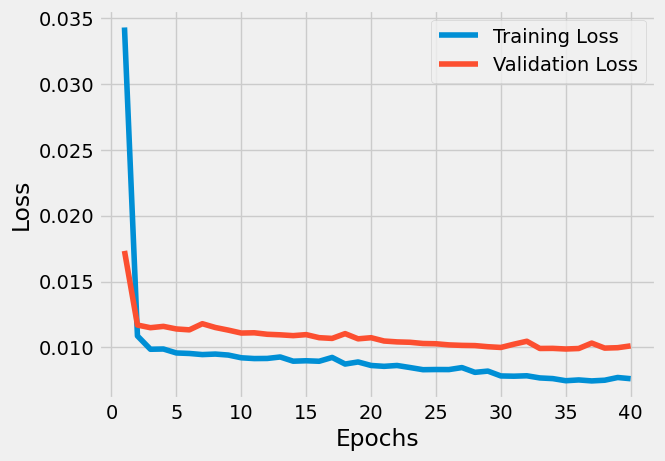

In [ ]:
best_epoch = 40
epochs = range(1, best_epoch+1)

# Plot training and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Make predictions on the test set
y_pred = lstm_model.predict(x_test)

# Inverse transform the scaled predictions to get actual temperature values
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred = scaler.inverse_transform(y_pred)

# Calculate the Root Mean Squared Error (RMSE) as a measure of prediction accuracy
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Plot the actual vs. predicted temperatures
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Temperature')
plt.plot(y_pred, label='Predicted Temperature')
plt.legend()
plt.xlabel('Day')
plt.ylabel('Temperature (°F)')
plt.title('Daily Max Temperature Prediction with Univariate LSTM')
plt.show()

After rigorous experimentation and training linear regression, univariate LSTM, and multivariate LSTM, I decided to choose the univariate LSTM model that was trained on NCEI's data because it exhibited superior performance. Beyond the metrics, the decision was also informed by the qualities of the data itself. NCEI's data presented as the more dependable and consistent source of information, enabling the machine learning to make more accurate and reliable predictions. Furthermore, the accessibility of NCEI's data, available for extraction without additional cost makes it a better option than VS's data.

## Kalshi's API Trading

### Predict today's maximum temperature

In [ ]:
# Get recent NCEI's data to predict
start_date = datetime.datetime.strptime("2023-08-01", "%Y-%m-%d").date()
last_date = datetime.date.today() - datetime.timedelta(days=1)
api_recent = pd.DataFrame()

while start_date <= last_date:
    end_date = min(start_date + datetime.timedelta(days=100), last_date)
    params = {
        "datasetid": "GHCND",
        "stationid": "GHCND:USW00094728",
        "startdate": start_date,
        "enddate": end_date,
        "units": "standard",
        "datatypeid": "AWND,PRCP,SNOW,SNWD,TMAX,TMIN,WT01,WT03,WT08",
        "limit": 1000
    }
    # API request
    response = requests.get(url, params=params, headers={"token": "hQjOAltlsPnryPJlIEkjkzQqJFPtGOpe"})
    start_date = end_date + datetime.timedelta(days=1)
    if response.status_code == 200:
        print("API request successful")
        # Convert JSON to DataFrame
        json_data = pd.DataFrame(response.json()["results"])
        result = pd.DataFrame(json_data)
        api_recent = api_recent.append(json_data)
    else:
        print(f"API request failed with status code {response.status_code}")

ncei_df_recent = ncei_processing(api_recent)

API request successful


C:\Users\pnhua\AppData\Local\Temp\ipykernel_17432\2761922362.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  api_recent = api_recent.append(json_data)


In [ ]:
# Extract the temperature values and convert them to an array
temperatures_recent = ncei_df_recent['max temp'].values.astype(float)

# Normalize the data to be in the range [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
temperatures_recent = scaler.fit_transform(temperatures_recent.reshape(-1, 1))

# Create sequences for training
x, y = create_sequences(temperatures_recent, seq_length)

# Predict tomorrow's temperature
y_pred_recent = lstm_model.predict(x)

# Inverse transform the predicted value to get the actual temperature
y_pred_recent = scaler.inverse_transform(y_pred_recent)
y_pred_today = y_pred_recent[-1]
print(f"The maximum temperature today is: {y_pred_today}")

2/2 [==============================] - 0s 18ms/step
The maximum temperature today is: [75.280754]


### Implement Kalshi's API to trade

In [ ]:
demo_email = "jazzmine@bu.edu"
demo_password = "" 

demo_api_base = "https://demo-api.kalshi.co/trade-api/v2"

exchange_client = ExchangeClient(exchange_api_base = demo_api_base, email = demo_email, password = demo_password)

# Check on the exchange status to confirm proper connection
print(exchange_client.get_exchange_status())

{'exchange_active': True, 'trading_active': True}


In [ ]:
# Get today date
today_date = datetime.date.today()
month = today_date.strftime("%b")
day = today_date.strftime("%d")
year = today_date.strftime("%y")

# Get today's event and market tickers
event_ticker = 'HIGHNY-' + year + month.upper() + day

event_params = {'event_ticker': event_ticker}
event_response = exchange_client.get_event(**event_params)

market = event_response['markets']
market_ticker = pd.DataFrame(event_response['markets'])['ticker']

print(f'Today\'s event ticker is {event_ticker}')
print('The available tickers today are ')
print(market_ticker)

Today's event ticker is HIGHNY-23OCT12
The available tickers today are 
0      HIGHNY-23OCT12-T63
1    HIGHNY-23OCT12-B63.5
2    HIGHNY-23OCT12-B65.5
3    HIGHNY-23OCT12-B67.5
4    HIGHNY-23OCT12-B69.5
5      HIGHNY-23OCT12-T70
Name: ticker, dtype: object


In [ ]:
temp_list = []

for m in market:
    a = m['subtitle'].split()
    if "or" in a:
        num = int(a[0][:-1])
        temp_list.append(num)
    else:
        num1 = int(a[0][:-1])
        num2 = int(a[-1][:-1])
        temp_list.append((num1 + num2)/2)


i = np.argmax(abs(np.array(temp_vals) - y_pred_today))
ticker = market_ticker[i]

print(f'The ticker with the furthest distance from the predicted temperature is {ticker}')

The ticker with the furthest distance from the predicted temperature is HIGHNY-23OCT12-T63


In [ ]:
# Execute trading
order_params = {'ticker':ticker,
                'client_order_id':str(uuid.uuid4()),
                'type':'market',
                'action':'buy',
                'side':'no',
                'count':1000,
                'yes_price':None, # yes_price = 100 - no_price
                'no_price':None, # no_price = 100 - yes_price
                'expiration_ts':None,
                'sell_position_floor':None,
                'buy_max_cost':None}

exchange_client.create_order(**order_params)

{'ticker': 'HIGHNY-23OCT12-T63', 'client_order_id': 'da0895b5-34af-43f7-8535-136880013a98', 'side': 'no', 'action': 'buy', 'count': 10, 'type': 'market'}


{'order': {'order_id': 'c451e462-45df-49f2-86da-e734e4e79754',
  'user_id': 'f0d45de2-4106-4791-a2c4-1cedbe54988c',
  'ticker': 'HIGHNY-23OCT12-T63',
  'status': 'resting',
  'yes_price': 1,
  'no_price': 99,
  'created_time': '2023-10-13T02:03:26.104023Z',
  'expiration_time': None,
  'action': 'buy',
  'side': 'no',
  'type': 'market',
  'client_order_id': 'da0895b5-34af-43f7-8535-136880013a98',
  'order_group_id': ''}}

## Conclusion
Overall, I am pleased about how the common task's completion turned out. I have fulfilled all project requirements, starting with the identification of 5 data sources for predicting daily climate events. I then meticulously crafted Python scripts to gather historical data from each of these sources, facilitating the training of a machine learning model to make daily climate event predictions. The project also included the creation of informative plots that showcased the model's predictions in comparison to ground truth values over time. Last but not least, I implemented Kalshi's API to allow for automated trading. 

While the project has demonstrated the potential of the model, I acknowledge that further improvements are attainable to reduce prediction errors. Because we must make bets on a very specific temperature range of one Fahrenheit degree, I tried to stay away from betting "yes" on the predicted temperature. Instead, I adopted a pragmatic trading strategy that favored "no" decisions for temperature ranges distant from the prediction, increasing the likelihood of accurate predictions. 

Additionally, I recognized the occasional lag in NCEI data updates, often following weekends and holidays, affecting trading accuracy. Given more time, I aspire to explore alternative machine learning techniques, data fusion methods, and hyperparameter fine-tuning to enhance the predictive modeling's robustness and performance.